# Clustering a subset of the complete dataset on Min_Max scaled data

#### A note on converting Jupyter Notebook output to MS Word Documents

- The best way to convert the ipynb file (Jupyter Notebook) to a docx file is to follow the two step approach explained in: https://blog.ouseful.info/2017/06/13/using-jupyter-notebooks-for-assessment-export-as-word-docx-extension/, i.e. run the following two commands on the anaconda command line
- Step 1: $ jupyter nbconvert --no-input --to html file_name.ipynb (use --no-input to exclude code cells, i.e. convert only markdown cells)

- Step 2: $ pandoc -s file_name.html -o file_name.docx
- This approach produces, by far, the best quality docx ouput, no distortion of either the text or the graphs.  The only drawback is that it include the hidden code cells made by the "hide all" extension.  I have to manually delete those contents from the produced docx file.
#### convert ijynb to a docx file
- https://nbconvert.readthedocs.io/en/latest/index.html
- install nbconvert [pip install nbconvert]
- install pandoc: [https://github.com/jgm/pandoc/releases/tag/3.1.3]

In [1]:
import sys

oneDrive_root={}
oneDrive_root[1]="C:\\Users\\Chihyang\OneDrive for Business\\"
oneDrive_root[2]="C:\\Users\\Chihyang\OneDrive for Business\\"
oneDrive_root[3]="C:\\Users\\tsaic\\OneDrive - State University of New York at New Paltz\\"  # laptop

site=3   # the short or long business OneDrive directory name
lib_dir=oneDrive_root[site]+'\\Prudentia\\Tsaipy'
# append additional library path for this study
sys.path.append(lib_dir)

In [2]:
### import basic modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


### load modules from my library
from WFN_lib.WindFarm import distance2center, write_df_sub2Excel
from WFN_lib.mongodb_util import flatten_dictionary
from WFN_lib.cluster_classify import cluster_analysis
from dbconnect.mongodb import cursor_to_dataframe3



### import mongodb modules
from pymongo import MongoClient
import pymongo
from dbconnect import mongodb as mdb

In [3]:
### import sklearn modules
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import joblib

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

<div class="alert alert-block alert-info"><b>Connect to MongoDb:</b>

</div>

In [4]:
## pymongo connect to mongodb database and collection
db_name = "Windfarm_6000"
client = MongoClient('localhost', 27017)  # connect to the db engine
db = client[db_name]
### test connections to the database collections
coll_data=db['Data_S6000']
coll_res = db['Results_S6000']
print(f"Rows in coll_data = {coll_data.count_documents({})}")
print(f"Rows in coll_res = {coll_res.count_documents({})}")

Rows in coll_data = 6000
Rows in coll_res = 6000


<div class="alert alert-block alert-success"><b>Separate clean and non-clean samples:</b> The goal is to train a classifier on clean vs non-clean samples. For H1, clean vs non-clean are determined by human for training the classifer.  The classifer is then applied to the 3000 samples in H2 to separate clean and non-clean samples.
<ul>
<li>There are 31 feature variables.</li>
<li>H1 variables are minmax normalized for all variables</li>
Mli>H2 variables are normalized based on H1 normalization parameters.</li>
</ul></div>

#### Data Retrieval and Preprocessing
- Retrive the H1 and H2 samples with the 31 feature varaibles into two dataframe, each with 3000 rows and 31 variables
- Normalize H1 data using minmax normalization.
- Use the normalization parameters obtained from H1 to normalize H2 
- For H1 dataframe, add a __class variable__ where all 3000 cases are defaulted to __class 0__.
- Retreive the id's of the 843 clean samples and change their __class variable value to 1__.

In [5]:
## retrieve H1 data from mongodb to a dataframe and normalize it.
res1=db['Data_S6000'].find({"site":"H1"},{'v31':1})
df_H1 = cursor_to_dataframe3(res1,"_id")
row_index1 = df_H1.index
column_names1 = df_H1.columns

## Min_max normalization of df_H1 using sklearng
## load a saved normalization parameters from a saved file
scaler = MinMaxScaler()
scaler = joblib.load('.//trained_models//Minmax_scaler_v31_H1_S3000.joblib')

df_H1 = scaler.fit_transform(df_H1)
df_H1 = pd.DataFrame(df_H1, index= row_index1, columns = column_names1)
print("Shape of df_H1: ",df_H1.shape)
## save the normalization parameters
#norm_param = scaler.get_params()

## retrieve H2 data from mongodb to a dataframe.
res2=db['Data_S6000'].find({"site":"H2"},{'v31':1})
df_H2 = cursor_to_dataframe3(res2,"_id")
row_index2 = df_H2.index
column_names2 = df_H2.columns
## use the normalization parameters developed on df_H1 to normalize df_H2
#scaler.set_params(**norm_param)
df_H2 = scaler.fit_transform(df_H2)
df_H2 = pd.DataFrame(df_H2, index=row_index2, columns = column_names2)
print("Shape of df_H2: ",df_H2.shape)

Shape of df_H1:  (3000, 31)
Shape of df_H2:  (3000, 31)


In [6]:
## Check if the values are consistent with those in M2
df_H1.head(3)

,v31.spectralCentroid,v31.spectralCrest,v31.spectralDecrease,v31.spectralEntropy,v31.spectralFlatness,v31.spectralFlux,v31.spectralKurtosis,v31.spectralRolloffPoint,v31.spectralSkewness,v31.spectralSlope,...,v31.PR,v31.Fo,v31.AMfactor,v31.DAM,v31.peakloc_unweightedSPL,v31.L63,v31.L125,v31.L250,v31.L500,v31.L1000
H1_0001,0.017638,0.815540,0.996951,0.228597,0.029063,0.001635,0.006851,0.023762,0.077191,0.997410,...,0.064817,1.000000,0.047060,0.015886,0.000000,0.046839,0.034494,0.040067,0.005090,0.007652
H1_0002,0.011442,0.939524,0.991424,0.105126,0.032293,0.684277,0.004065,0.008786,0.067042,0.526505,...,0.007353,0.888889,0.017838,0.013268,0.065217,0.099330,0.100103,0.029094,0.012593,0.017782
H1_0003,0.031291,0.689000,0.999256,0.350613,0.022545,0.048706,0.000823,0.045246,0.023726,0.958707,...,0.097601,0.777778,0.181323,0.150206,0.565217,0.121841,0.102376,0.084847,0.089479,0.278842


### Add the class variable to df_H1

In [7]:
## add a class column to the dataframe with default value of 0
df_H1['class']=0
print(df_H1.shape)
### Retreive the sample ID of the 843 clean samples
S843 = db['H1_Clean_Subsets'].find_one({'_id':'S843'})['list']   # get the ID name list of the 843 clean samples
#### Change the class value of the 843 clean samples to 1
df_H1.loc[S843,'class']=1
print(df_H1['class'].value_counts())


(3000, 32)
0    2157
1     843
Name: class, dtype: int64


In [8]:
print(df_H1.shape)
print(df_H2.shape)

(3000, 32)
(3000, 31)


<div class="alert alert-block alert-info"><b>Classification:</b> A three step approach to determine and train a classification model.  Two classifiers are tested.
<ul>
<li>SVC</li>
<li>Random Forest</li>
</ul></div>

In [9]:
## v31_minmax as X and class as y (clean vs non-clean)
X = df_H1.iloc[:,0:-1]  # the last column 'class' is the class column
y = df_H1['class']

### Test a SVC classifier

#### Step 1: Use GridSearch to determine the hyperparameters

In [10]:
## Grid search for the best hyperparameters for SVC
param_grid1 = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf']}
grid1 = GridSearchCV(SVC(), param_grid1, refit=True, verbose=3, n_jobs=-1)  # use default 5-fold cross validation (cv=5)
grid1.fit(X, y)
print(grid1.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}


#### Step 2: Use a ten-fold cross-validation to evaluate the model

In [11]:
## Test the best hyperparameters using cross-validation
n_folds=10
model_svc = SVC(**grid1.best_params_)  ## use ** to unpack the dictionary
cv1 = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
scores1 = cross_val_score(model_svc, X, y, scoring='accuracy', cv=cv1, n_jobs=-1)
print(f"Average Accuracy from the {n_folds} trials: {scores1.mean():.3f}  with standard deviation: {scores1.std():.3f}")

Average Accuracy from the 10 trials: 0.796  with standard deviation: 0.023


#### Step 3: Fit the model with the best hyperparameters and save the trained model

In [12]:
## Use the best hyperparameters to fit SVC and save the trained model
model_svc.fit(X, y)
## Save the trained model
joblib.dump(model_svc, '.\\trained_models\\SVC_H1_v31_minmax_clean_vs_non_clean.joblib')
print("Model saved")

y_pred = model_svc.predict(X)
print(f"Accuracy: {accuracy_score(y, y_pred):.3f}")
print(confusion_matrix(y, y_pred))

## find precision, recall, f1-score
print(classification_report(y, y_pred))


Model saved
Accuracy: 0.850
[[1969  188]
 [ 263  580]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      2157
           1       0.76      0.69      0.72       843

    accuracy                           0.85      3000
   macro avg       0.82      0.80      0.81      3000
weighted avg       0.85      0.85      0.85      3000



### Test a Random Forest classifier

#### Step 1: Use GridSearch to determine the hyperparameters

In [13]:
## Grid search for the best hyperparameters for RandomForestClassifier
param_grid2 = {'n_estimators': [10, 20, 30, 50], 'max_features': [10, 15, 31], 'max_depth': [10, 15, 20]}
grid2 = GridSearchCV(RandomForestClassifier(), param_grid2, refit=True, verbose=3, n_jobs=-1)
grid2.fit(X, y)
print(grid2.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'max_depth': 10, 'max_features': 15, 'n_estimators': 50}


#### Step 2: Use a ten-fold cross-validation to evaluate the model

In [14]:
## Test the best hyperparameters using cross-validation
n_folds=10
model_rmft = RandomForestClassifier(**grid2.best_params_)
cv2 = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
scores2 = cross_val_score(model_rmft, X, y, scoring='accuracy', cv=cv2, n_jobs=-1)
print(f"Average Accuracy from the {n_folds} trials: {scores2.mean():.3f}  with standard deviation: {scores2.std():.3f}")


Average Accuracy from the 10 trials: 0.783  with standard deviation: 0.019


#### Step 3: Fit the model with the best hyperparameters and save the trained model

In [15]:
# fit the model with the best hyperparameters
model_rmft.fit(X, y)
## Save the trained model
joblib.dump(model_rmft, '.\\trained_models\\RandomForest_H1_v31_minmax_clean_vs_non_clean.joblib')
print("Model saved")

y_pred = model_rmft.predict(X)
print(f"Accuracy: {accuracy_score(y, y_pred):.3f}")
print(confusion_matrix(y, y_pred))

## find precision, recall, f1-score
print(classification_report(y, y_pred))

Model saved
Accuracy: 0.954
[[2136   21]
 [ 116  727]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2157
           1       0.97      0.86      0.91       843

    accuracy                           0.95      3000
   macro avg       0.96      0.93      0.94      3000
weighted avg       0.96      0.95      0.95      3000



No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.995


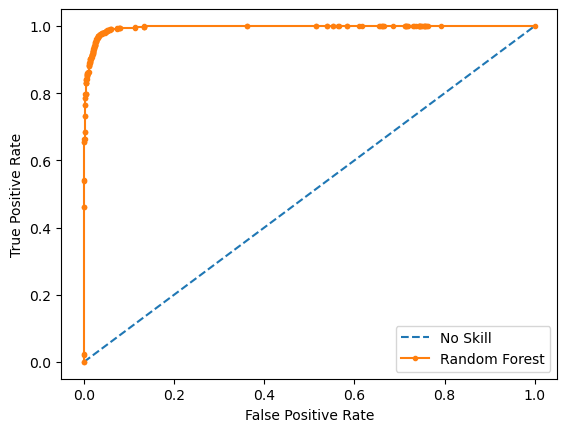

In [16]:
# ROC curve for the RandomForest model
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y))]
# predict probabilities
rf_probs = model_rmft.predict_proba(X)
# keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y, ns_probs)
rf_auc = roc_auc_score(y, rf_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(y, rf_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()


In [17]:
### Find the feature importance
importances = model_rmft.feature_importances_
indices = np.argsort(importances)[::-1]

feature_names = X.columns
print("Feature ranking:")
for i in range(X.shape[1]):
    print(f"{i+1}. feature {indices[i]}: {feature_names[indices[i]]} ({importances[indices[i]]:.3f})")
print("Feature ranking done")
## find the corresponding feature names
feature_names = X.columns
print(f"Feature names: {feature_names}")



Feature ranking:
1. feature 19: v31.pos_slope (0.079)
2. feature 30: v31.L1000 (0.079)
3. feature 20: v31.neg_slope (0.071)
4. feature 18: v31.peakval (0.061)
5. feature 8: v31.spectralSkewness (0.055)
6. feature 4: v31.spectralFlatness (0.038)
7. feature 6: v31.spectralKurtosis (0.035)
8. feature 10: v31.spectralSpread (0.034)
9. feature 21: v31.PR (0.034)
10. feature 15: v31.ratioLCLA (0.032)
11. feature 12: v31.harmonicRatio (0.032)
12. feature 16: v31.diffLCLA (0.030)
13. feature 26: v31.L63 (0.030)
14. feature 23: v31.AMfactor (0.029)
15. feature 5: v31.spectralFlux (0.028)
16. feature 24: v31.DAM (0.027)
17. feature 28: v31.L250 (0.026)
18. feature 9: v31.spectralSlope (0.026)
19. feature 13: v31.LA (0.025)
20. feature 14: v31.ratioLGLA (0.023)
21. feature 27: v31.L125 (0.022)
22. feature 29: v31.L500 (0.022)
23. feature 7: v31.spectralRolloffPoint (0.021)
24. feature 3: v31.spectralEntropy (0.021)
25. feature 0: v31.spectralCentroid (0.020)
26. feature 1: v31.spectralCrest (0.02

### Apply the trained classifer to H2

In [18]:
print(df_H2.shape)
print(df_H1.head(3))

(3000, 31)
         v31.spectralCentroid  v31.spectralCrest  v31.spectralDecrease  \
H1_0001              0.017638           0.815540              0.996951   
H1_0002              0.011442           0.939524              0.991424   
H1_0003              0.031291           0.689000              0.999256   

         v31.spectralEntropy  v31.spectralFlatness  v31.spectralFlux  \
H1_0001             0.228597              0.029063          0.001635   
H1_0002             0.105126              0.032293          0.684277   
H1_0003             0.350613              0.022545          0.048706   

         v31.spectralKurtosis  v31.spectralRolloffPoint  v31.spectralSkewness  \
H1_0001              0.006851                  0.023762              0.077191   
H1_0002              0.004065                  0.008786              0.067042   
H1_0003              0.000823                  0.045246              0.023726   

         v31.spectralSlope  ...    v31.Fo  v31.AMfactor   v31.DAM  \
H1_0001  

In [19]:
## Use the trained model to predict the class of the H2 data
y_pred_svc = model_svc.predict(df_H2)
## find the number clean cases and non-clean cases
print(f"Number of clean cases: {np.sum(y_pred_svc)}")
print(f"Number of non-clean cases: {len(y_pred_svc)-np.sum(y_pred_svc)}")


Number of clean cases: 617
Number of non-clean cases: 2383


In [20]:
y_pred_rmft = model_rmft.predict(df_H2)
## find the number clean cases and non-clean cases
print(f"Number of clean cases: {np.sum(y_pred_rmft)}")
print(f"Number of non-clean cases: {len(y_pred_rmft)-np.sum(y_pred_rmft)}")

Number of clean cases: 362
Number of non-clean cases: 2638


#### Append H2 classification result from both approaches to df_H2


In [21]:
df_H2_class = df_H2.copy()
df_H2_class['class_svc']=y_pred_svc
df_H2_class['class_rmft']=y_pred_rmft

In [22]:
#### Check the overlap between the two models
print(f"Number of overlapping clean cases: {np.sum(y_pred_svc & y_pred_rmft)}")

Number of overlapping clean cases: 239


In [23]:
df_H2_class.head(3)

,v31.spectralCentroid,v31.spectralCrest,v31.spectralDecrease,v31.spectralEntropy,v31.spectralFlatness,v31.spectralFlux,v31.spectralKurtosis,v31.spectralRolloffPoint,v31.spectralSkewness,v31.spectralSlope,...,v31.AMfactor,v31.DAM,v31.peakloc_unweightedSPL,v31.L63,v31.L125,v31.L250,v31.L500,v31.L1000,class_svc,class_rmft
H2_0001,0.005632,0.973885,0.992231,0.032404,0.003608,0.036352,0.023006,0.005659,0.189086,0.930674,...,0.134755,0.157878,0.021739,0.112431,0.239937,0.190387,0.093880,0.280321,0,0
H2_0002,0.001613,0.984752,0.996335,0.023273,0.000692,0.080071,0.014018,0.000689,0.138962,0.949881,...,0.103570,0.268546,0.369565,0.127201,0.198834,0.089432,0.073755,0.493840,0,0
H2_0003,0.018495,0.862324,0.999656,0.151617,0.017284,0.009619,0.001202,0.027532,0.047971,0.989650,...,0.035255,0.058365,0.000000,0.113237,0.243552,0.072689,0.057389,0.080989,0,0


In [24]:
## Create folders to save the wave file by categories, clean and non-clean

In [25]:
wav_source_dir = dir_in_wav = ".//wav//wav_files//"
destination_dir ="F://split_wav_files//"

In [26]:
import shutil
for s in df_H2_class.index:
    file_wav = s+".wav"
    if df_H2_class.loc[s,'class_svc']==1:
        dir_out_wav = destination_dir+"SVC//Clean//"
    else:
        dir_out_wav = destination_dir+"SVC//Non-Clean//"
    ## copy the wav file to the corresponding cluster folder
    shutil.copy(wav_source_dir+file_wav, dir_out_wav)


In [27]:
for s in df_H2.index:
    file_wav = s+".wav"
    if df_H2_class.loc[s,'class_rmft']==1:
        dir_out_wav = destination_dir+"RandomForest//Clean//"
    else:
        dir_out_wav = destination_dir+"RandomForest//Non-Clean//"
    ## copy the wav file to the corresponding cluster folder
    shutil.copy(wav_source_dir+file_wav, dir_out_wav)    

<div class="alert alert-block alert-info"><b>Clustering:</b> Cluster the clean samples in H1 and use the clustering model to cluster the predicted clean samples in H2. 

<b>!!!To be updated later.</b>
</div>

In [ ]:
df_H1_S843 = df_H1.loc[S843]
df_H1_S843=df_H1_S843.drop(columns='class')
df_H1_S843.shape

In [ ]:
df_S843_res, _ =cluster_analysis(df_H1_S843, [3,4,5,6], random_state=42, scaled_data=None,n_init=10, max_iter=300, tol=0.0001,
                                 save_model_dir='.//trained_models//',model_file_name='KMeans_H1_S843_K=')

In [ ]:
## test clustering result on one K value, 3, 4, 5, 6
df_S843_res['K=3'].value_counts()

### Cluster H2 based on the clutering models developed from H1

In [ ]:
### Extract clean samples from H2
df_H2_clean = df_H2[df_H2['class_svc']==1]
df_H2_clean.shape
df_H2_clean_copy = df_H2_clean.iloc[:,:-2].copy()  # do not copy the last two columns, which are class variables from the two models
print(df_H2_clean.shape,df_H2_clean_copy.shape)

In [ ]:
for k in [3,4,5,6]:
    ## retrieve train clustering model
    model = joblib.load(f'.\\Results_H1\\Kmeans_model_K={k}.joblib')
    ## predict the cluster of the clean samples
    df_H2_clean[f'K={k}']=model.predict(df_H2_clean_copy)

print(df_H2_clean.shape)
    

In [ ]:
## test result
print(df_H2_clean.iloc[:10,-4:])